# **III. Palmprint Authentication Application** 
An application for Authentication using Siamese Network Model from part II.

### Step 1. Load the saved model

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import register_keras_serializable

In [23]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function, Variable
from torchvision import transforms, models, datasets
from torch.utils.data import Dataset
import itertools
import matplotlib.pyplot as plt
import time
from PIL import Image, ImageDraw, ImageFont
import copy
import numpy as np
import cv2
from torchvision.utils import save_image
from scipy.misc import face
from networks.ROILAnet import ROILAnet
from networks.TPSGridGen import TPSGridGen
from skimage.transform import resize

torch.set_default_dtype(torch.float64)

In [24]:
@register_keras_serializable()
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

@register_keras_serializable()
def loss(margin=1):
    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )
        
    return contrastive_loss

In [38]:
# Load the saved model with the custom objects
siamese = tf.keras.models.load_model("siamese_model.keras", custom_objects={'contrastive_loss': loss(), 'euclidean_distance': euclidean_distance})

# Verify the model architecture and weights
siamese.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_17       │ (None, 100)       │  1,401,456 │ input_layer_13[0… │
│ (Functional)        │                   │            │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 1)         │          0 │ functional_17[0]… │
│                     │                   │            │ functional_17[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,776,006 (10.59 MB)

 Trainable params: 1,374,542 (5.24 MB)

 Non-trainable params: 26,920 (105.16 KB)

 Optimizer params: 1,374,544 (5.24 MB)

### Step 2. ROI Extraction

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ROIModelPath = 'weights/ROI_extractor_augmented_TJ-NTU.pt' # path to the train ROI model

In [40]:
def loadROIModel(weightPath: str = None):
    """
    @weightPath: path to file ROILAnet() weights
    load localization network with pretrain weights
    """
    model = ROILAnet()
    model.load_state_dict(torch.load(weightPath, map_location=torch.device(device)))
    model = model.to(device)
    model.eval()
    model.requires_grads=False
    return model
def getThinPlateSpline(target_width: int = 112, target_height: int = 112) -> torch.Tensor:
    """
    @target_width: desired I_ROI output width
    @target_height: desired I_ROI output height
    make instance of TPS grid generator
    """
    # Create points on palm with TPS
    target_control_points = torch.Tensor(list(itertools.product(
        torch.arange(-1.0, 1.00001, 1.0),
        torch.arange(-1.0, 1.00001, 1.0),
    )))
    gridgen = TPSGridGen(target_height=target_height, target_width=target_width, target_control_points=target_control_points)
    gridgen = gridgen.to(device)
    return gridgen
def getOriginalAndResizedInput(path: str = None) -> (np.ndarray, torch.Tensor, torch.Tensor):
    """
    @path: Image needs to be loaded from database
     This function loads a resized image from a directory given in the path.
     After resizing to 56x56 pixels, the original and resized images will be returned as triples (PILMain, source_image, resized)
    """
    if path is None:
        return (None, None)
    
    # Define transformer for resized input of feature extraction CNN
    resizeTranformer = transforms.Compose([
            transforms.Resize((56,56)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    PILMain = Image.open(path).convert(mode = 'RGB') # load image in PIL format
    sourceImage = np.array(PILMain).astype('float64') # convert from PIL to float64
    sourceImage = transforms.ToTensor()(sourceImage).unsqueeze_(0) # add first dimension, which is batch dim
    sourceImage = sourceImage.to(device) # load to available device

    resizedImage = resizeTranformer(PILMain)
    resizedImage = resizedImage.view(-1,resizedImage.size(0),resizedImage.size(1),resizedImage.size(2))
    resizedImage = resizedImage.to(device) # load to available device
    return (PILMain, sourceImage,resizedImage)
def getThetaHat(resizedImage: torch.Tensor = None, model = None) -> torch.Tensor: 
    """
    @resizedImage: Cut image
    @model: ROI Localisation network, generate a resized theta vector Image: the image needs to be loaded from the database via the getOriginalAndResizedInput function. 
     Here the theta vector is computed using the pre-trained network. The vector has size [9, 2] -> represents 9 pairs of x and y values
    """
    if resizedImage is None:
        return None
    
    with torch.no_grad(): # cancel gradients try to predict by ROI
        theta_hat = model.forward(resizedImage)
    theta_hat = theta_hat.view(-1, 2, 9) # split into vectors x and y -> theta_hat is initially a vector like [xxxxxxxxyyyyyyyyyy]
    theta_hat = torch.stack((theta_hat[:,0], theta_hat[:,1]),-1)
    return theta_hat
def sampleGrid(theta_hat: torch.Tensor = None, sourceImage: torch.Tensor = None, target_width: int = 112, target_height: int = 112 ) -> torch.Tensor:
    """
    @theta_hat: theta vector of the normalized xy coordinate pair
    @sourceImage: the original image without cropping or resizing
    @target_width: wide target IROI output
    @target_height: tall target IROI output
     Mesh samples from a given theta vector, source image, and mesh generator
    """
    gridgen = getThinPlateSpline(target_width, target_height)
    # Create grid points from the calculation of theta_hat vector
    source_coordinate = gridgen(theta_hat)
    # Create target grid - with target height and target width
    grid = source_coordinate.view(-1, target_height, target_width, 2).to(device)
    # Sample ROI from input image and generate T(theta_hat)
    target_image = F.grid_sample(sourceImage, grid,align_corners=False)
    return target_image
def printExtraction(target_image: torch.Tensor = None, source_image = None):
    """
    @source_image: print source_image in PIL format
    @target_image: print target_image as tensor (ROI)
    """
    # Prepare to display -> return from gpu if needed
    target_image = target_image.cpu().data.numpy().squeeze().swapaxes(0, 1).swapaxes(1, 2)
    target_image = Image.fromarray(target_image.astype('uint8'))
    plt.imshow(source_image)
    plt.show() # show original image
    plt.imshow(target_image)
    plt.show() # show ROI image
def loadCNNModel(weightPath: str = None):
    """
    @weightPath: path to ROILAnet() weights loadCNNModel file with pretrained weights
    """
    model = models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(class_names))
    model.load_state_dict(torch.load(weightPath, map_location=torch.device(device)))
    model.to(device)
    return model
def getIROI(model, input):
    resizedImage = F.interpolate(input, (56, 56))
    theta_hat = getThetaHat(resizedImage=resizedImage, model=model) # generate theta with normalized ROI
    IROI = sampleGrid(theta_hat=theta_hat, sourceImage=input, target_width=224, target_height=224) # get ROI from original image
    IROI.to(device)
    return IROI
def markImage(image, theta):
    nimg = np.array(image)
    ocvim = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
    for idx, coord in enumerate(theta):
        currX = coord[0]
        currY = coord[1]
        x = int((ocvim.shape[1] - 1) / (1 + 1) * (currX - 1) + ocvim.shape[1])
        y = int((ocvim.shape[0] - 1) / (1 + 1) * (currY - 1) + ocvim.shape[0])
        ocvim = cv2.circle(ocvim,(x,y),6,(200,0,0),2)
        ocvim = cv2.putText(
            ocvim,  # numpy array on which text is written
            str(idx),  # text
            (x, y),  # position at which writing has to start
            cv2.FONT_HERSHEY_SIMPLEX,  # font family
            1,  # font size
            (209, 80, 0, 255),  # font color
            3)
    ocvim = ocvim[...,::-1]
    return ocvim
def getOriginalAndResizedInput(PILMain) -> (np.ndarray, torch.Tensor, torch.Tensor):
    """
    @path: image path retrieved from database
     This function loads a resized image from a directory provided in the path.
     After resizing to 56x56 pixels, the original and resized images will be returned.
     as triples (PILMain, source_image, resizedImage)
    """
    if PILMain is None:
        return (None, None)
    
    # Define transformer for resized input of CNN feature extraction
    resizeTranformer = transforms.Compose([
            transforms.Resize((56,56)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    # PILMain = PILMain.convert(mode = 'RGB') # load image in PIL format
    sourceImage = np.array(PILMain).astype('float64') # convert from PIL to float64
    sourceImage = transforms.ToTensor()(sourceImage).unsqueeze_(0) # add first dimension, which is batch dim
    sourceImage = sourceImage.to(device) # load to available device

    resizedImage = resizeTranformer(PILMain)
    resizedImage = resizedImage.view(-1,resizedImage.size(0),resizedImage.size(1),resizedImage.size(2))
    resizedImage = resizedImage.to(device) # load to available device
    return (PILMain, sourceImage,resizedImage)

In [41]:
#load localisation netowork for ROI extraction
localisationNetwork = loadROIModel(ROIModelPath) # load localisation network

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [42]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms

def roiExtraction(path: str):
    # Define transformations
    grayTransformer = transforms.Compose([
        transforms.CenterCrop((224,224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    CNNtransformer = transforms.Compose([
        transforms.Grayscale(),
        transforms.CenterCrop((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3,1,1)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Read the filename from path
    inputPIL = Image.open(path).convert('RGB')
    fname = os.path.basename(path)
    pname = f"roi_{fname.split('.')[0]}.JPEG"
    
    # Plotting and ROI extraction process
    plt.figure(figsize=(20,20))  # specifying the overall grid size
    
    # Original Input Image
    plt.subplot(4,1,1)
    plt.imshow(inputPIL)
    plt.title('Input Image')
    
    # Preprocess images for the model
    (PILMain, sourceImage,resizedImage) = getOriginalAndResizedInput(inputPIL)
    sourceImage = torch.stack([sourceImage.squeeze()])
    resizedImage = torch.stack([resizedImage.squeeze()])
    
    # Get the normalized transformation parameters (theta_hat)
    theta_hat = getThetaHat(resizedImage, localisationNetwork)
    
    # Mark the estimated points on the image
    plt.subplot(4,1,2)
    plt.imshow(markImage(inputPIL, theta_hat[0]))
    plt.title('Estimated Points')
    
    # Sample and extract the ROI
    IROI = sampleGrid(theta_hat=theta_hat, sourceImage=sourceImage, target_width=300, target_height=300)
    IROI = IROI[0]
    
    # Plot the extracted ROI
    plt.subplot(4,1,3)
    plt.imshow((IROI.cpu()[0]), cmap='gray')
    plt.title('Extracted ROI')
    plt.axis('off')
    
    # Save the ROI image using the directory from path
    save_dir = os.path.dirname(path)
    plt.savefig(os.path.join(save_dir, pname), bbox_inches='tight', pad_inches=0)
    plt.title('Extracted ROI')
    plt.axis('off')

    plt.show()
    # Save the ROI image using the directory from path
    # save_dir = os.path.dirname(path)
    # plt.savefig(os.path.join(save_dir, pname), bbox_inches='tight', pad_inches=0)
    # plt.close()

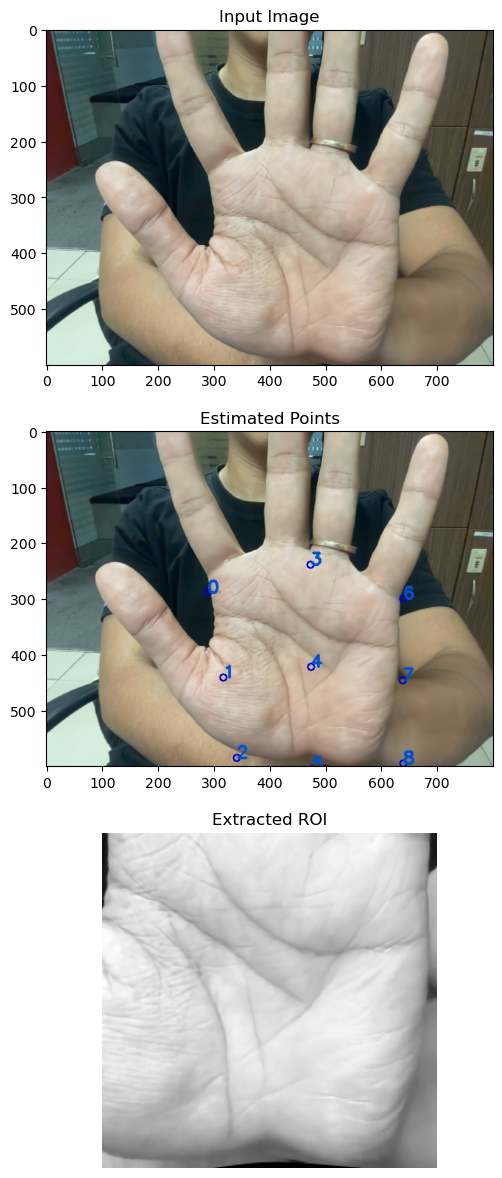

In [43]:
roiExtraction('authen_images/hand1_1.JPEG')

### Step 3: Load the extracted ROI image

In [44]:
import cv2
import matplotlib.pyplot as plt

def crop_center(img, scale=0.8):
    (h, w) = img.shape[:2]
    center_x, center_y = w // 2, h // 2
    new_w = int(w * scale)
    new_h = int(h * scale)
    x1 = center_x - (new_w // 2)
    y1 = center_y - (new_h // 2)
    x2 = x1 + new_w
    y2 = y1 + new_h
    return img[y1:y2, x1:x2]

def process_image(image_path, target_size=(128, 128)):
    img = cv2.imread(image_path)
    img_cropped = crop_center(img, scale=0.8)
    img_resized = resize(img_cropped, target_size)
    return img_resized

In [45]:
image_path = "images/"

def loadROIs(names):
    images = []
    for name in names:
        img = cv2.imread(image_path + name + ".JPEG")
        img = resize(img, (128, 128))
        images.append((img, name))
    plt.imshow(np.concatenate([img for img, _ in images], axis=1))
    plt.axis('off')
    return prepareROIsInput(images)

def prepareROIsInput(images):
    rois = []
    for img, name in images:
        img = np.array(img)
        img = np.expand_dims(img, axis=0)
        rois.append((img, name))
    print(rois[0][0].shape)
    return rois

In [46]:
def predict_pairs(rois):
    predictions = []
    num_rois = len(rois)
    
    for i in range(num_rois):
        for j in range(i + 1, num_rois):
            roi1, name1 = rois[i]
            roi2, name2 = rois[j]
            
            # Ensure roi1 and roi2 are distinct
            if not np.array_equal(roi1, roi2):
                # Predict similarity score between roi1 and roi2
                prediction = siamese.predict([roi1, roi2])[0][0]
                predictions.append((roi1, name1, roi2, name2, prediction))
    
    return predictions

In [47]:
def visualize_pairs(predictions, to_show=None, num_col=4):
    num_pairs = len(predictions)
    if to_show is None:
        to_show = num_pairs  # Display all pairs if to_show is not specified
    to_show = min(to_show, num_pairs)  # Ensure we don't attempt to show more pairs than available

    num_row = (to_show + num_col - 1) // num_col  # Calculate the number of rows needed

    fig, axes = plt.subplots(num_row, num_col, figsize=(14, 2.4 * num_row))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)  # Reduce the margins between plots

    # Flatten the axes array if there's only one row
    if num_row == 1:
        axes = axes[np.newaxis, :]

    for i in range(to_show):
        row = i // num_col
        col = i % num_col

        roi1, name1, roi2, name2, prediction = predictions[i]

        # Concatenate ROI1 and ROI2 side by side
        concatenated_image = np.concatenate((roi1.squeeze(), roi2.squeeze()), axis=1)
        
        axes[row, col].imshow(concatenated_image, cmap='gray')
        axes[row, col].set_axis_off()
        axes[row, col].set_title(f'Prediction: {prediction:.2f}\n{name1} & {name2}', fontsize=12)

    # Turn off any unused subplots
    for i in range(to_show, num_row * num_col):
        row = i // num_col
        col = i % num_col
        axes[row, col].axis('off')

    plt.show()

In [35]:
roiExtractionOnly('images/user2_3.tiff')

NameError: name 'roiExtractionOnly' is not defined

(1, 128, 128, 3)


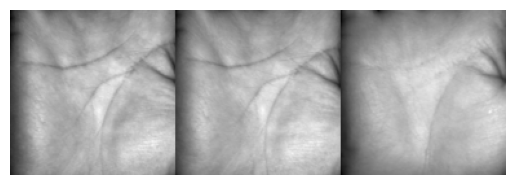

In [48]:
# Tongji data
rois_tongji = loadROIs(["00012", "00018", "00032"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


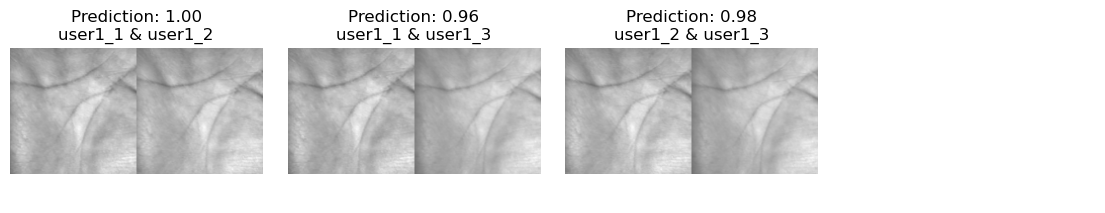

In [49]:
predictions_tongji = predict_pairs(rois_tongji)
visualize_pairs(predictions_tongji)

(1, 128, 128, 3)


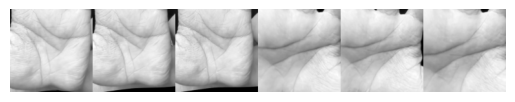

In [50]:
# Tongji data
rois_tongji = loadROIs(["user1_1", "user2_1"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


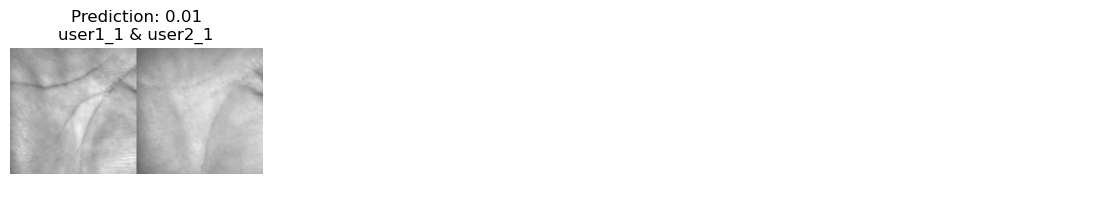

In [51]:
predictions_tongji = predict_pairs(rois_tongji)
visualize_pairs(predictions_tongji)

(1, 128, 128, 3)


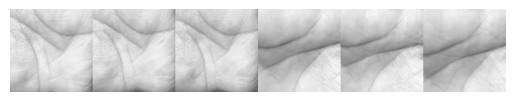

In [52]:
# Actual data
rois = loadROIs(["roi17", "roi18", "roi19", "roi21", "roi22", "roi23"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


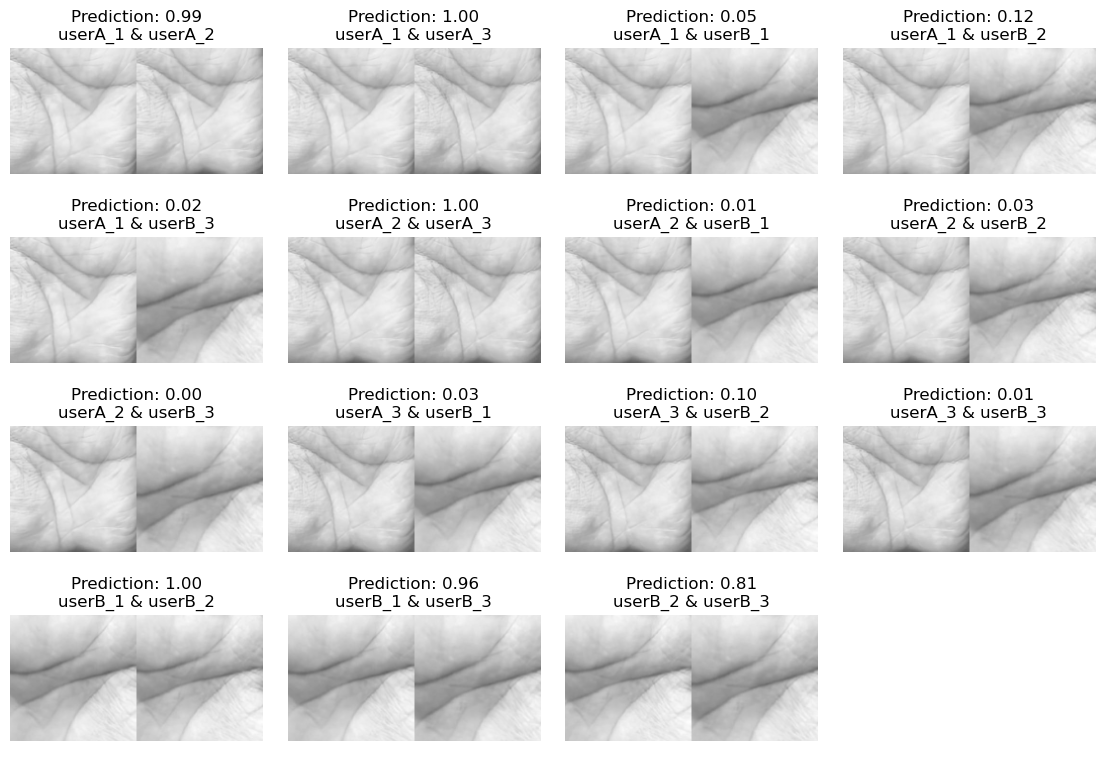

In [53]:
predictions = predict_pairs(rois)
visualize_pairs(predictions)

In [54]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms

def roiExtractionOnly(path: str):
    # Define transformations
    grayTransformer = transforms.Compose([
        transforms.CenterCrop((224,224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    CNNtransformer = transforms.Compose([
        transforms.Grayscale(),
        transforms.CenterCrop((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3,1,1)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Read the filename from path
    inputPIL = Image.open(path).convert('RGB')
    fname = os.path.basename(path)
    pname = f"roi_{fname.split('.')[0]}.JPEG"
    
    # Preprocess images for the model
    (PILMain, sourceImage,resizedImage) = getOriginalAndResizedInput(inputPIL)
    sourceImage = torch.stack([sourceImage.squeeze()])
    resizedImage = torch.stack([resizedImage.squeeze()])
    
    # Get the normalized transformation parameters (theta_hat)
    theta_hat = getThetaHat(resizedImage, localisationNetwork)
    
    # Sample and extract the ROI
    IROI = sampleGrid(theta_hat=theta_hat, sourceImage=sourceImage, target_width=300, target_height=300)
    IROI = IROI[0]
    
    # Plot the extracted ROI
    plt.figure(figsize=(8, 8))
    plt.imshow((IROI.cpu()[0]), cmap='gray')
    plt.axis('off')
    
    # Save the ROI image using the directory from path
    save_dir = os.path.dirname(path)
    plt.savefig(os.path.join(save_dir, pname), bbox_inches='tight', pad_inches=0)
    plt.close()

In [57]:
roiExtractionOnly("authen_images/hand1_1.jpeg")

In [58]:
roiExtractionOnly("images/user1_3.tiff")

(-0.5, 615.5, 615.5, -0.5)

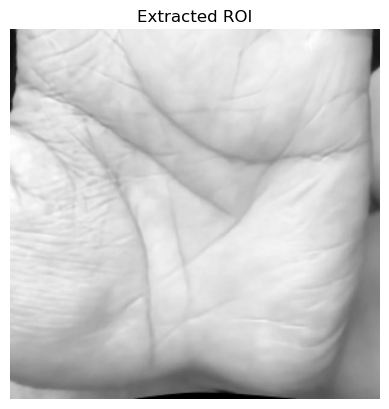

In [59]:
# Plot the extracted ROI
plt.subplot(1,1,1)
plt.imshow(Image.open('authen_images/roi_hand1_1.jpeg'), cmap='gray')
plt.title('Extracted ROI')
plt.axis('off')

In [60]:
image_path = "authen_images/"

def loadAuthenROIs(names):
    images = []
    for name in names:
        img = cv2.imread(image_path + name + ".JPEG")
        img = resize(img, (128, 128))
        images.append(img)
    return prepareAuthenROIsInput(images)

def prepareAuthenROIsInput(images):
    rois = []
    for img in images:
        img = np.array(img)
        img = np.expand_dims(img, axis=0)
        rois.append(img)
    print(rois[0][0].shape)
    return rois

## Demo App

In [62]:
import os
import cv2
import tkinter as tk
from tkinter import Label, Button, Frame
from PIL import Image, ImageTk, ImageOps
import torch
from torchvision import transforms
from skimage import io
from skimage.transform import resize
import time

class CameraApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Palmprint Authentication App")
        self.root.geometry("1200x600")
        self.type = "register"

        # Create a frame for the camera preview
        self.camera_frame = tk.Frame(root, width=640, height=480)
        self.camera_frame.grid(row=0, column=0, padx=10, pady=10)

        # Create a label for the camera preview
        self.camera_label = Label(self.camera_frame)
        self.camera_label.pack()

        # Create a label for the hand image
        self.hand_image_label = Label(self.camera_frame)
        self.hand_image_label.place(x=0, y=0)  # Place it at the top-left corner of the camera_frame

        # Create a frame for the authentication images and buttons
        self.auth_frame = tk.Frame(root, width=400, height=600)
        self.auth_frame.grid(row=0, column=1, padx=10, pady=10)

        # Create labels and image views for the authentication images
        self.original_label = Label(self.auth_frame, text="Original Image")
        self.original_label.grid(row=0, column=0, pady=10)

        self.original_image_view = Label(self.auth_frame)
        self.original_image_view.grid(row=1, column=0, pady=10)

        self.verify_label = Label(self.auth_frame, text="Verify Image")
        self.verify_label.grid(row=0, column=1, pady=10)

        self.verify_image_view = Label(self.auth_frame)
        self.verify_image_view.grid(row=1, column=1, pady=10)

        # Create a label to display the match prediction score
        self.prediction_score = 0  # Initial prediction score
        self.match_label = Label(self.auth_frame, text=f"Match: {self.prediction_score}")
        self.update_match_label()
        self.match_label.grid(row=2, columnspan=2, pady=10)

        # Create Register and Login buttons
        self.register_button = Button(self.auth_frame, text="Register", command=self.register)
        self.register_button.grid(row=3, column=0, pady=10, sticky="ew")

        self.login_button = Button(self.auth_frame, text="Login", command=self.login)
        self.login_button.grid(row=3, column=1, pady=10, sticky="ew")

        # Center the Register and Login buttons horizontally
        self.auth_frame.grid_columnconfigure(0, weight=1)
        self.auth_frame.grid_columnconfigure(1, weight=1)

        # Initialize the video capture
        self.cap = cv2.VideoCapture(0)
        if not self.cap.isOpened():
            print("Error: Could not open video device.")
            self.cap = None
        else:
            self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
            self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
            # self.flip_camera()

        # Load the authentication images
        self.load_auth_images()

        # Load the hand image
        self.hand_image = Image.open('authen_images/hand.png').convert("RGBA")

        # Variables for continuous image capture
        self.continuous_capture = False
        self.continuous_capture_interval = 1  # in seconds

    def flip_camera(self):
        # Flip the camera horizontally
        self.cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'MJPG'))
        self.cap.set(cv2.CAP_PROP_FPS, 30)
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
        self.cap.set(cv2.CAP_PROP_FOURCC, cv2.VideoWriter_fourcc(*'MJPG'))

    def update_camera_preview(self):
        if self.cap is None:
            return

        ret, frame = self.cap.read()
        if ret:
            # Convert the frame to RGBA mode
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGBA)
            img = Image.fromarray(frame)

            # Resize hand image to match the camera preview size
            hand_image_resized = self.hand_image.resize(img.size, Image.Resampling.LANCZOS)

            # Overlay the hand image on the camera preview
            img_with_hand = Image.alpha_composite(img.convert("RGBA"), hand_image_resized)

            # Convert back to RGB for displaying
            img_with_hand = img_with_hand.convert("RGB")
            
            self.imgtk = ImageTk.PhotoImage(image=img_with_hand)
            self.camera_label.imgtk = self.imgtk
            self.camera_label.configure(image=self.imgtk)

        self.camera_label.after(10, self.update_camera_preview)

    def register(self):
        if self.cap is None:
            return

        self.type = "register"
        self.register_button.config(text="Done", command=self.stop_capture)

        self.start_continuous_capture()

    def login(self):
        if self.cap is None:
            return

        self.type = "login"
        self.login_button.config(text="Done", command=self.stop_capture)

        self.start_continuous_capture()

    def start_continuous_capture(self):
        self.prediction_score = 0  # Reset prediction score
        self.update_match_label()

        self.continuous_capture = True
        self.continuous_capture_loop()

    def continuous_capture_loop(self):
        if self.continuous_capture:
            if self.type == "register":
                self.capture_original_image()
                self.root.after(3000, self.continuous_capture_loop)
            else:
                self.capture_verify_image()
                self.root.after(1000, self.continuous_capture_loop)

    def stop_capture(self):
        self.continuous_capture = False
        self.register_button.config(text="Register", command=self.register)
        self.login_button.config(text="Login", command=self.login)

    def capture_original_image(self):
        if self.cap is None:
            return
        
        ret, frame = self.cap.read()
        if ret:
            resized_image = cv2.resize(frame, (800, 600))
            cv2.imwrite('authen_images/original.JPEG', resized_image)
            # Perform ROI extraction
            roiExtractionOnly('authen_images/original.JPEG')
            self.load_auth_images()  # Reload authentication images after capture

    def capture_verify_image(self):
        if self.cap is None:
            return

        ret, frame = self.cap.read()
        if ret:
            resized_image = cv2.resize(frame, (800, 600))
            cv2.imwrite('authen_images/verify.JPEG', resized_image)
            # Perform ROI extraction for verify image
            roiExtractionOnly('authen_images/verify.JPEG')
            self.load_auth_images()
            rois = loadAuthenROIs(["roi_original", "roi_verify"])
            self.prediction_score = siamese.predict([rois])[0][0]
            self.update_match_label()

            # Stop continuous capture if prediction score reaches threshold
            if self.prediction_score > 0.5:
                self.continuous_capture = False

    def load_auth_images(self):
        original_image_path = 'authen_images/roi_original.JPEG'
        verify_image_path = 'authen_images/roi_verify.JPEG'

        if os.path.exists(original_image_path):
            original_image = io.imread(original_image_path)
            original_image = resize(original_image, (200, 200))
            original_image = (original_image * 255).astype('uint8')
            original_image_pil = Image.fromarray(original_image)
            original_image_pil = ImageOps.fit(original_image_pil, (200, 200))
            self.original_image_tk = ImageTk.PhotoImage(image=original_image_pil)
            self.original_image_view.configure(image=self.original_image_tk)
        else:
            self.original_image_view.configure(image='')

        if os.path.exists(verify_image_path):
            verify_image = io.imread(verify_image_path)
            verify_image = resize(verify_image, (200, 200))
            verify_image = (verify_image * 255).astype('uint8')
            verify_image_pil = Image.fromarray(verify_image)
            verify_image_pil = ImageOps.fit(verify_image_pil, (200, 200))
            self.verify_image_tk = ImageTk.PhotoImage(image=verify_image_pil)
            self.verify_image_view.configure(image=self.verify_image_tk)
        else:
            self.verify_image_view.configure(image='')

    def update_match_label(self):
        if self.prediction_score >= 0.5:
            self.match_label.configure(text=f"Match: {self.prediction_score}", fg="green")
        else:
            self.match_label.configure(text=f"Match: {self.prediction_score}", fg="red")

    def on_closing(self):
        if self.cap:
            self.cap.release()
        self.root.destroy()

if __name__ == "__main__":
    root = tk.Tk()
    app = CameraApp(root)
    root.protocol("WM_DELETE_WINDOW", app.on_closing)
    app.update_camera_preview()  # Start camera preview
    root.mainloop()

(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(128, 128, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
rois = loadROIs(["roi_original", "roi_verify"])

predictions = predict_pairs(rois)
visualize_pairs(predictions)

In [ ]:
rois = loadAuthenROIs(["roi_original", "roi_verify"])

In [ ]:
prediction = siamese.predict(rois)[0][0]
print(prediction)